The goal here is to understand the properties of behavioural data and to compare the participants' responses to the responses of simulated agents with planning depth fixed at various levels.

In [1]:
# -*- coding: utf-8 -*-

#%matplotlib inline
import numpy as np
from scipy import io

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='white')
sns.set_palette("colorblind", n_colors=5, color_codes=True)

from os import listdir, name, sep
import pandas as pd

import sys, os
sys.path.append(os.pardir)

In [3]:
from helpers import load_and_format_data

### load behavioural data ###
path1 = '../data/OldAdults/space_adventure/Experiment/'
path2 = '../data/YoungAdults/space_adventure/Experiment/'

data_old, states_old, responses_old, valid_old = load_and_format_data(path1, cutoff=0)
data_young, states_young, responses_young, valid_young = load_and_format_data(path2, cutoff=0)

data_old['group'] = 'OA'
data_young['group'] = 'YA'

# add mean planning depths (merge on subject ID and block_index)
df = pd.read_excel('../data/SAT_singleMiniblocks.xlsx', dtype={'Subject_ID':object})
df = df.rename(columns={"Subject_ID":"ID", "Block_id":"block_index"})
data_old = pd.merge(left = data_old, right = df[df.Group==1][["ID","MeanPD","block_index"]], on=["ID","block_index"], how="left")
data_young = pd.merge(left = data_young, right = df[df.Group==0][["ID","MeanPD","block_index"]], on=["ID","block_index"], how="left")

data = pd.concat([data_old, data_young], ignore_index=True)

fraction of excluded participants  0.0
fraction of excluded participants  0.0


In [5]:
#%% plot design matrix X
from matplotlib import colors

def plot_design_matrix(matrix, name = "Design Matrix", footnote = ""):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1,1,1)
    #ax.set_aspect('equal')
    ax.set_title(name)
    divnorm = colors.TwoSlopeNorm(vcenter=0)                    
    plt.imshow(matrix, aspect='auto', cmap=plt.cm.ocean, norm=divnorm)
    ax.set_ylabel("miniblock")
    ax.set_xlabel("predictor")
    plt.colorbar()
    plt.figtext(0.5, 0.01, footnote, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.show()
    

In [9]:
#%%
from bayesian_linear_regression import BayesLinRegress

T = 100

def sample_posterior(data, states, responses):
    n_subs = len(np.unique(data.subject))
    y1 = data['log_rt_1'].values.reshape(n_subs, T).T
    
    models = []
    
    ######## predictors #########
    # All non-constant predictors are standardized according to Gelman 2007: mean zero, sd 1/2
    
    # predictor0: single intercept
    intercept = np.ones((T, n_subs, 1))
    
    # predictor1-4: phase indicators
    phases = data.phase.values.astype(int).reshape(n_subs, T).T - 1
    phase_indis = np.eye(4)[phases]
    
    # predictor5-6: steps indicator
    steps_three = np.expand_dims(np.bitwise_or(phase_indis[:,:,2].astype(int), phase_indis[:,:,3].astype(int)), -1)
    steps_indis = np.concatenate([1-steps_three, steps_three], -1)
    
    # predictor7-8: noise indicator
    noise_high = np.expand_dims(np.bitwise_or(phase_indis[:,:,1].astype(int), phase_indis[:,:,3].astype(int)), -1)
    noise_indis = np.concatenate([1-noise_high, noise_high], -1)
    
    # predictor9: log(miniblock number)
    log_mb_nr = np.log(np.expand_dims(data['block_number'].values.astype(int).reshape(n_subs, T).T, -1)) 
    log_mb_nr -= log_mb_nr.mean(0)
    log_mb_nr /= (2 * log_mb_nr.std(0)) 
          
    # predictor10: starting points of miniblock
    start_points = np.expand_dims(data.start_points.values.copy().reshape(n_subs, T).T, -1)
    start_points -= start_points.mean(0)
    start_points /= 2*start_points.std(0)

    # predictor11: planning depth
    meanpd = np.expand_dims(data.MeanPD.values.copy().reshape(n_subs, T).T, -1)
    meanpd -= meanpd.mean(0)
    meanpd /= 2 * meanpd.std(0)
    
    X = np.concatenate([phase_indis, noise_indis, steps_indis, log_mb_nr, start_points, meanpd], -1)
    pred_labels = ['intercept', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'noise_low', 'noise_high', 'steps_two', 'steps_three', 'log_mb_nr', 'start_points', 'mean_pd']
    
    # calc pearson r for predictors and plot their distribution over subjects
    X_corrcoefs = np.expand_dims(np.corrcoef(X[:,0,:], rowvar = False), -1)
    for i in range(1, n_subs):
        X_corrcoefs = np.concatenate([X_corrcoefs, np.expand_dims(np.corrcoef(X[:,i,:], rowvar = False), -1)], -1)
    pars = X_corrcoefs.shape[0]
    fig = plt.figure(figsize=(25, 15))
    fig.suptitle("dist of pearson r over subs")
    rs = [] # pearson r coefficients
    ls = [] # labels of correlated vars
    for i in range(pars):
        for j in range(9, pars):    # 7 to skip indicator correlations 
            if (j>i):
                rs.append(X_corrcoefs[i,j,:])
                ls.append(pred_labels[i+1] + ' ~ ' + pred_labels[j+1]) # +1 to skip intercept label
    plt.boxplot(rs, vert=0)
    ax = plt.axes()
    ax.set_yticklabels(ls)
    plt.tight_layout()
    plt.show()
    
    
    ######## model 1 #########
    description = 'log(RT_first_action) = b0 + b1 * log(miniblock_nr) + b2 * starting_points'
    X = np.concatenate([intercept, log_mb_nr, start_points], -1)
    plot_design_matrix(X[:,0,:],'Model 1',description)  # plot design matrix of first subject
    m1 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m1)

    
    ######### model 2 #########
    description = 'log(RT_first_action) = b0 + b1 * log(miniblock_nr) + b2 * starting_points + b3 * mean_PD'
    X = np.concatenate([X, meanpd], -1)   
    plot_design_matrix(X[:,0,:],'Model 2',description)  # plot design matrix of first subject
    m2 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m2)
    
   
    ######### model 3 #########
    description = 'log(RT_first_action) = b0 * noise_low + b1 * noise_high + b2 * log(miniblock_nr) + b3 * starting_points'
    X = np.concatenate([noise_indis, log_mb_nr, start_points], -1)         
    plot_design_matrix(X[:,0,:],'Model 3',description)  # plot design matrix of first subject
    m3 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m3)      


    ######### model 4 #########
    description = 'log(RT_first_action) = b0 * noise_low + b1 * noise_high + b2 * log(miniblock_nr) + b3 * starting_points + b4 * mean_PD'
    X = np.concatenate([X, meanpd], -1) 
    plot_design_matrix(X[:,0,:],'Model 4',description)  # plot design matrix of first subject
    m4 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m4)
    
    
    ######### model 5 #########
    description = 'log(RT_first_action) = b0 * noise_low + b1 * noise_high'
    X = noise_indis
    plot_design_matrix(X[:,0,:],'Model 5',description)  # plot design matrix of first subject
    m5 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m5)
    
    
    ######### model 6 #########
    description = 'log(RT_first_action) = b0 * noise_low + b1 * noise_high + b2 * log(miniblock_nr)'
    X = np.concatenate([noise_indis, log_mb_nr], -1)         
    plot_design_matrix(X[:,0,:],'Model 6',description)  # plot design matrix of first subject
    m6 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m6)
    
    
    ######### model 7 #########
    description = 'log(RT_first_action) = b0 * noise_low + b1 * noise_high + b2 * starting_points'
    X = np.concatenate([noise_indis, start_points], -1)         
    plot_design_matrix(X[:,0,:],'Model 7',description)  # plot design matrix of first subject
    m7 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m7)  
    
    
    ######### model 8 #########
    description = 'log(RT_first_action) = b0 * noise_low + b1 * noise_high + b2 * meanPD'
    X = np.concatenate([noise_indis, meanpd], -1)         
    plot_design_matrix(X[:,0,:],'Model 8',description)  # plot design matrix of first subject
    m8 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m8) 
    
    
    ######### model 9 #########
    description = 'log(RT_first_action) = b0 * noise_low + b1 * noise_high + b2 * starting_points + b3 * meanPD'
    X = np.concatenate([noise_indis, start_points, meanpd], -1)         
    plot_design_matrix(X[:,0,:],'Model 9',description)  # plot design matrix of first subject
    m9 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m9)      
    
    
    ######### model 10 #########
    description = 'log(RT_first_action) = b0 * noise_low + b1 * noise_high + b2 * log_mb_nr + b3 * meanPD '
    X = np.concatenate([noise_indis, log_mb_nr, meanpd], -1)         
    plot_design_matrix(X[:,0,:],'Model 10',description)  # plot design matrix of first subject
    m10 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)
    models.append(m10)     
        

    samples = []
    waic = []
    for m in models:
          samples.append(m.fit(num_samples=1000, warmup_steps=5000, summary=False))
          waic.append(m.waic())
          print('model waic', waic[-1])
        
    return samples, waic

/home/johannes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


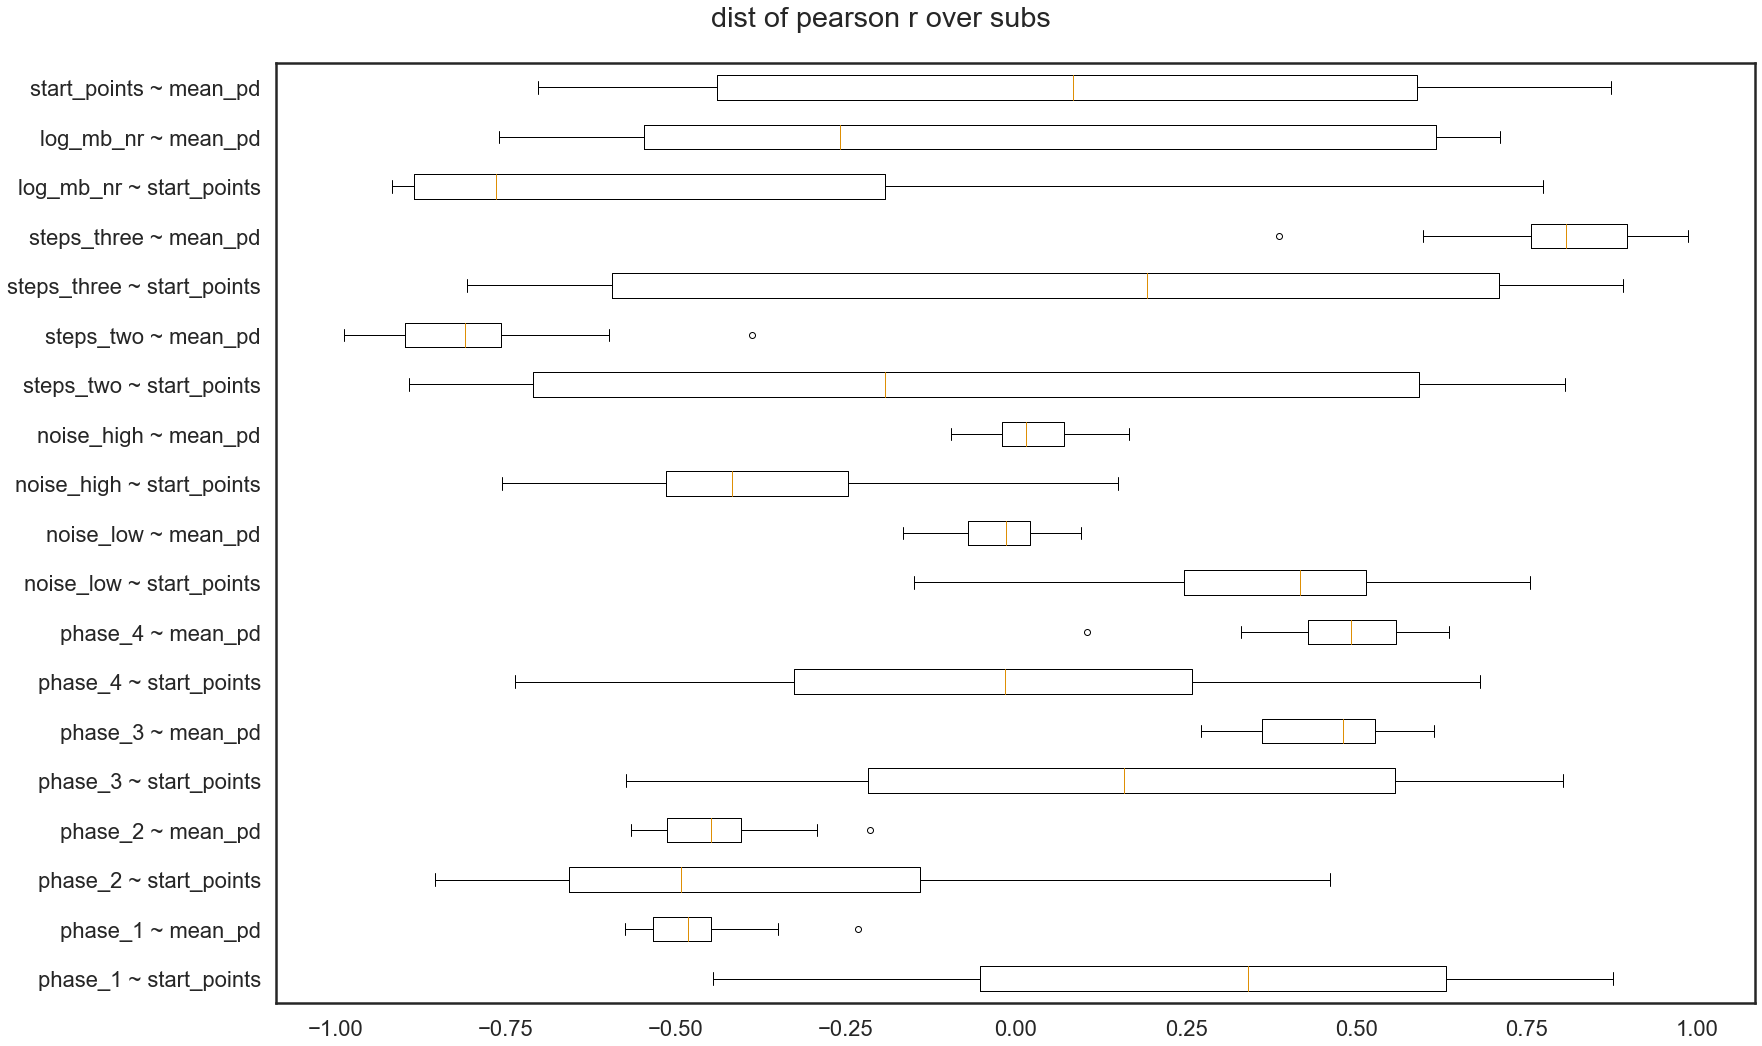

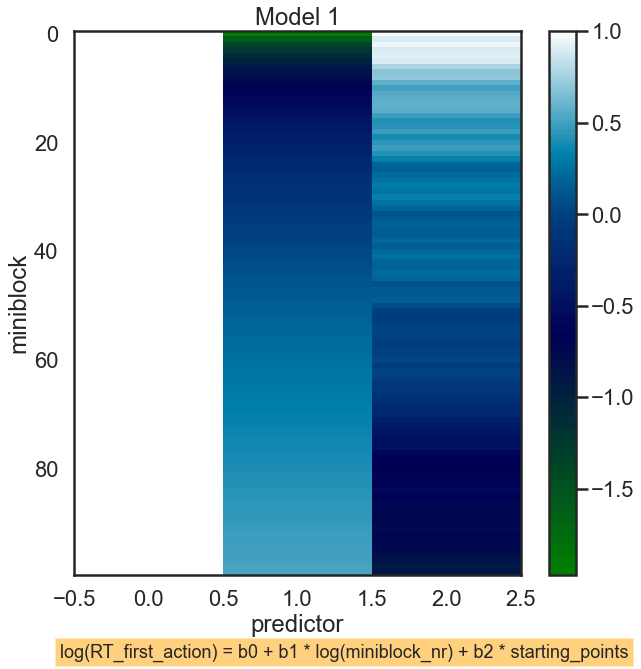

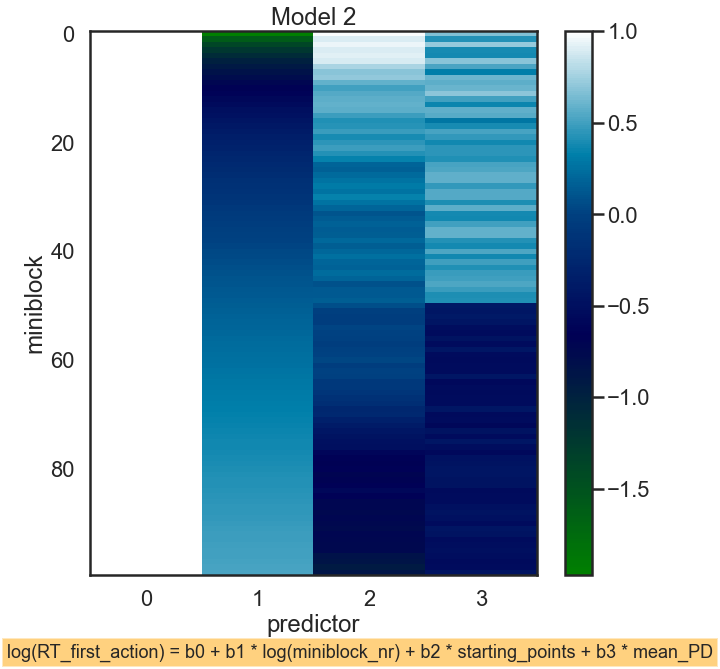

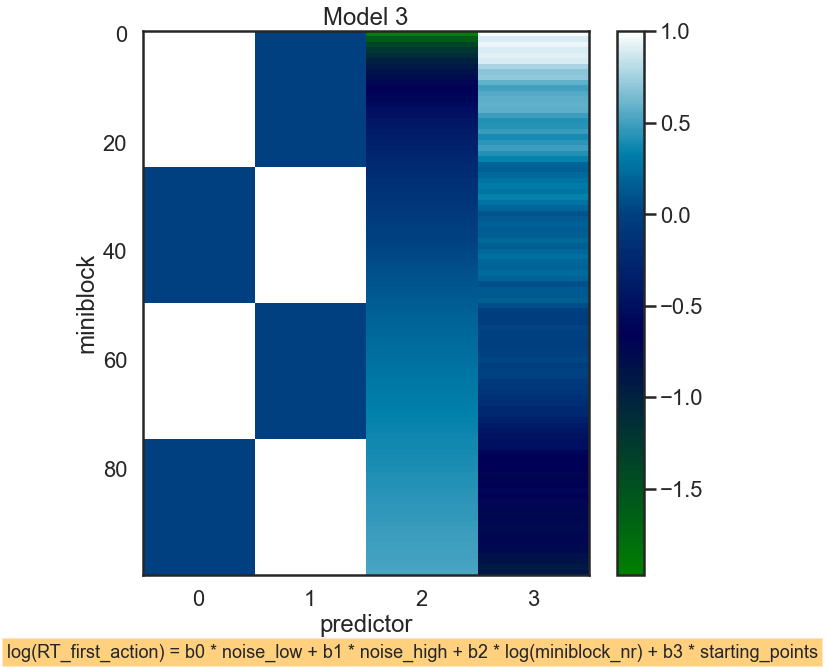

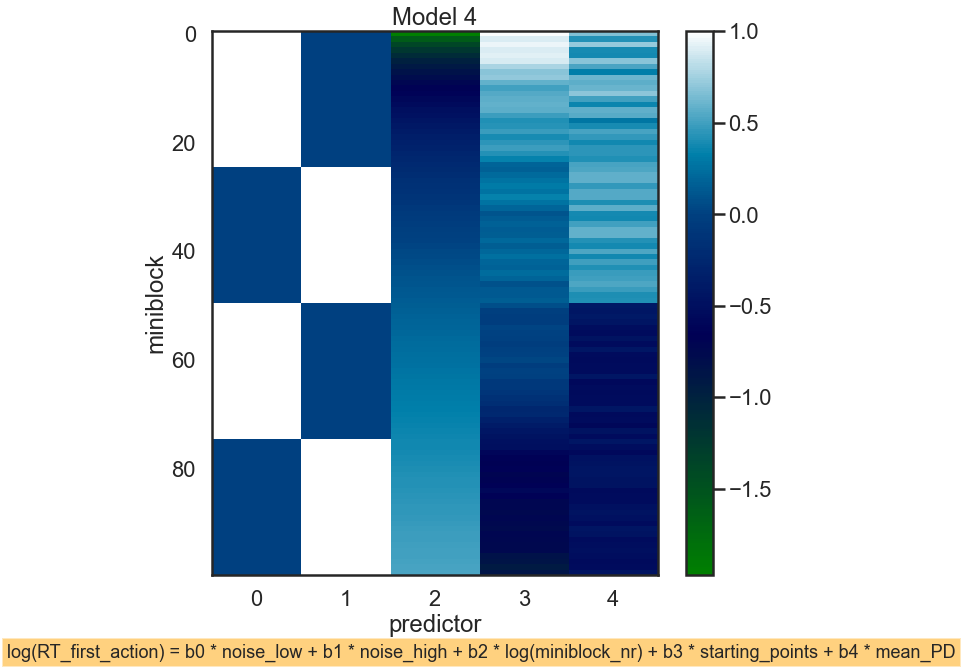

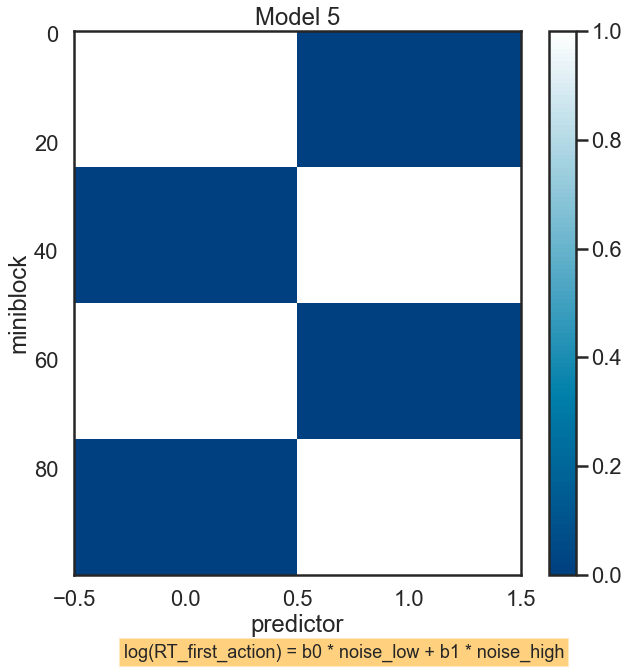

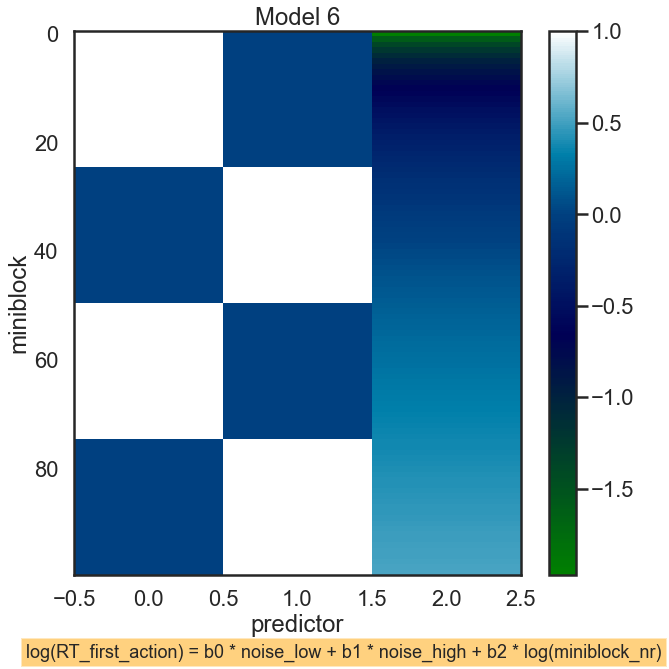

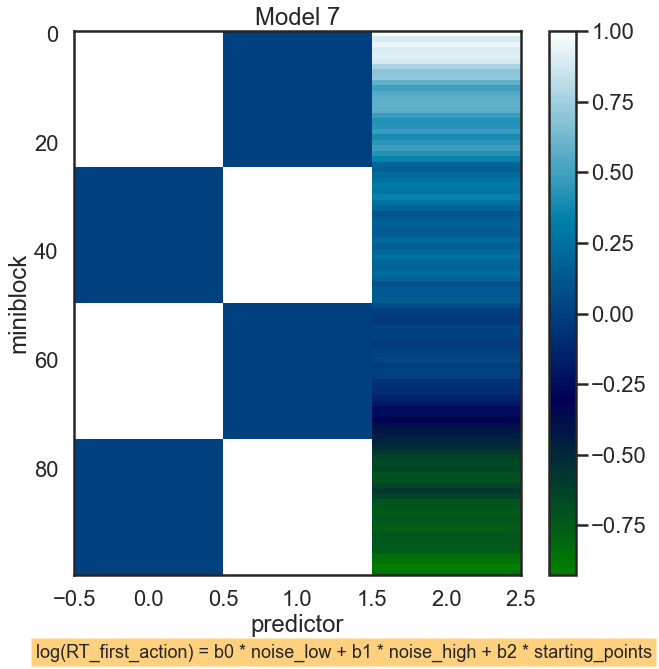

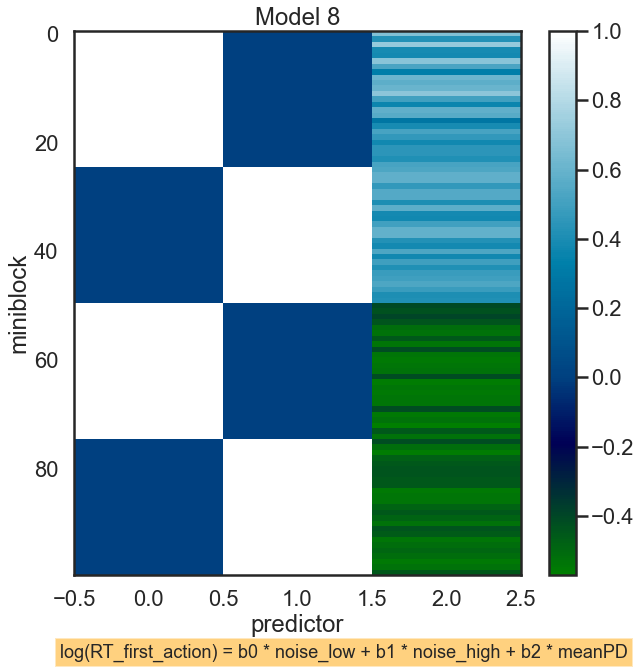

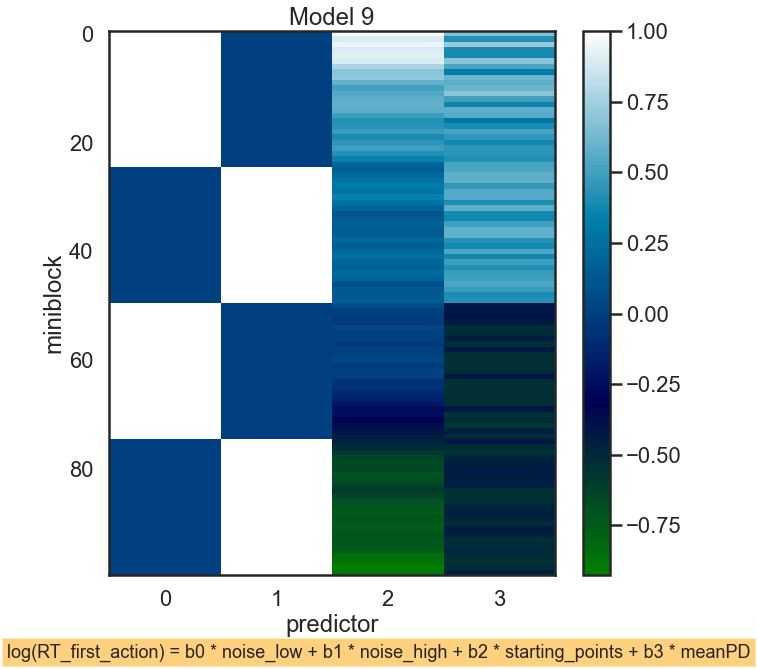

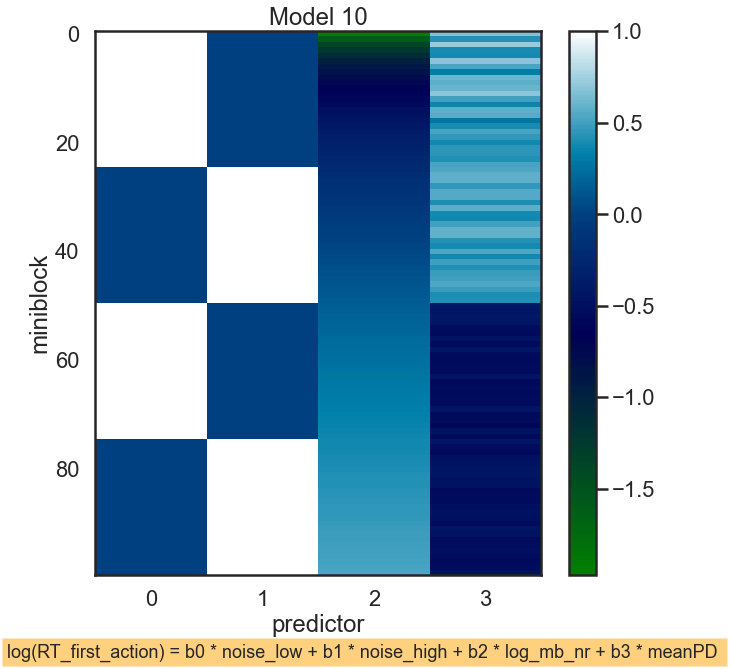

  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1632.2908


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1631.4073


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1636.3785


sample: 100%|██████████| 6000/6000 [02:06<00:00, 47.40it/s, 211 steps of size 8.77e-03. acc. prob=0.87] 


model waic -1637.3759


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1684.2983


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1638.5826


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1658.2288


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1660.4978


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -1654.2476


sample: 100%|██████████| 6000/6000 [02:00<00:00, 49.80it/s, 511 steps of size 8.44e-03. acc. prob=0.90] 


model waic -1634.3341


In [10]:
samples_old, waic_old = sample_posterior(data_old, states_old, responses_old)

/home/johannes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


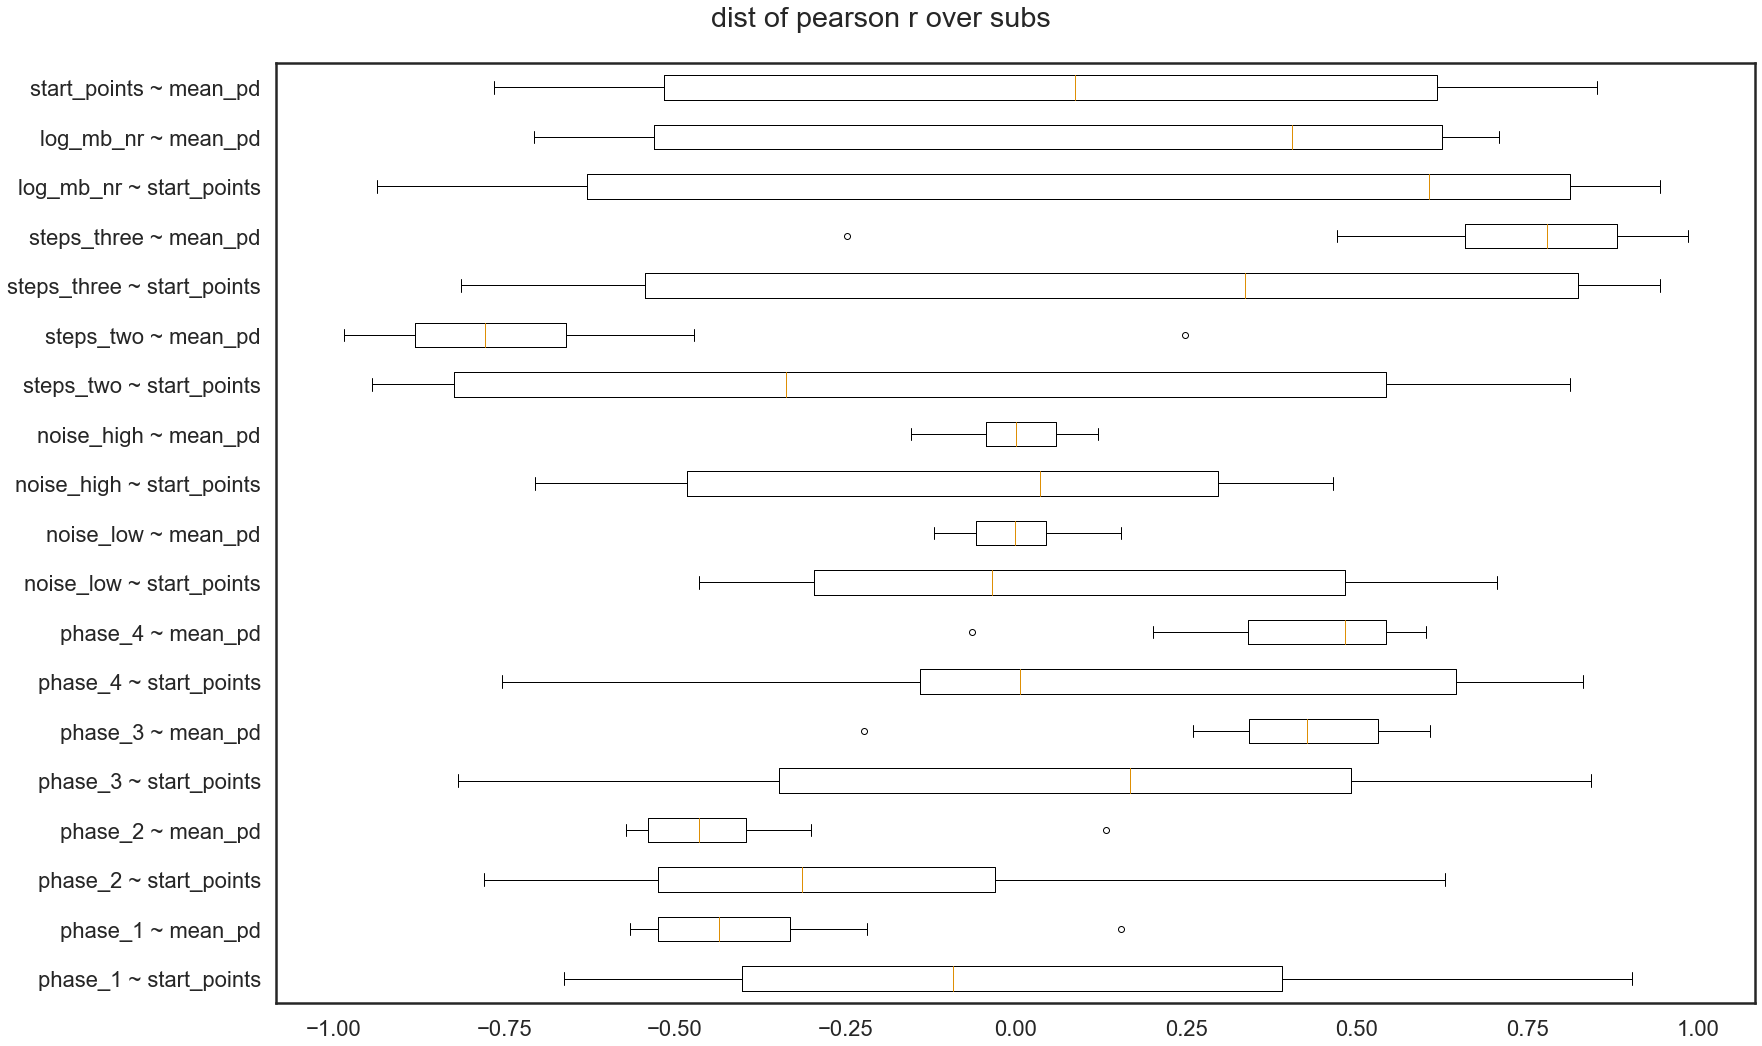

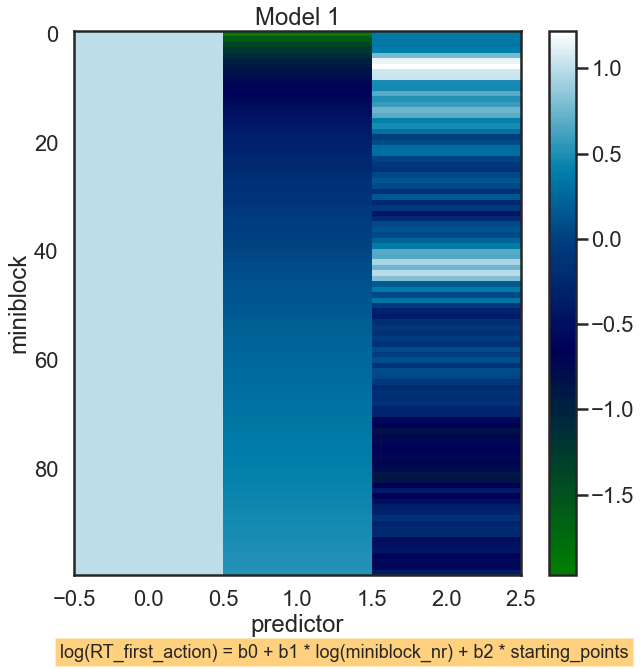

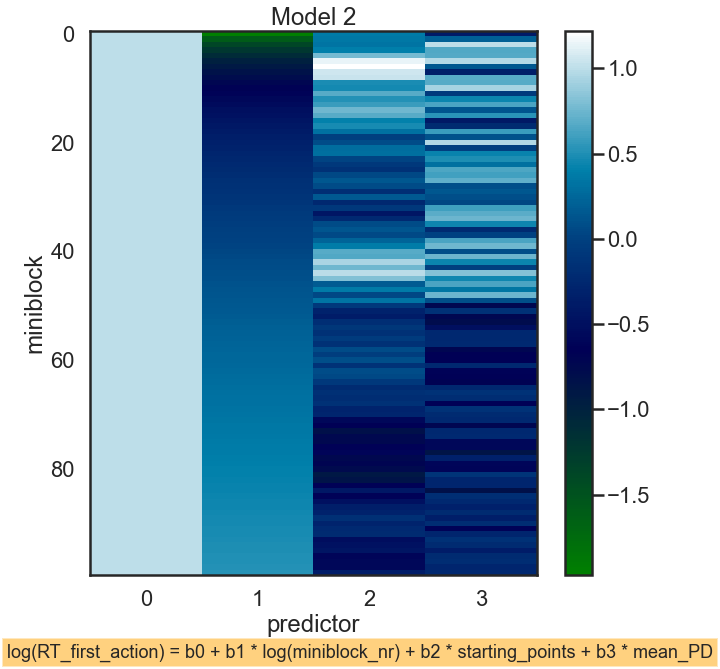

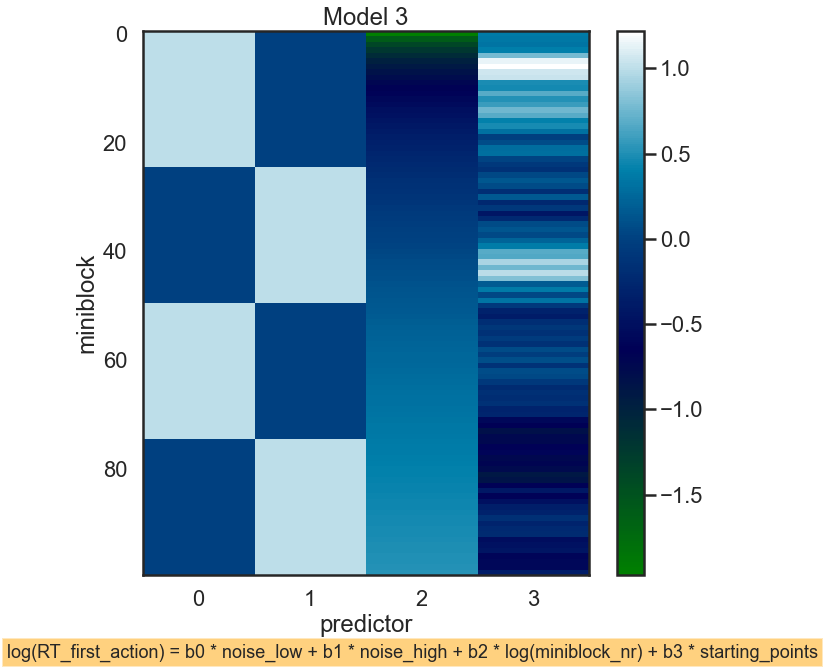

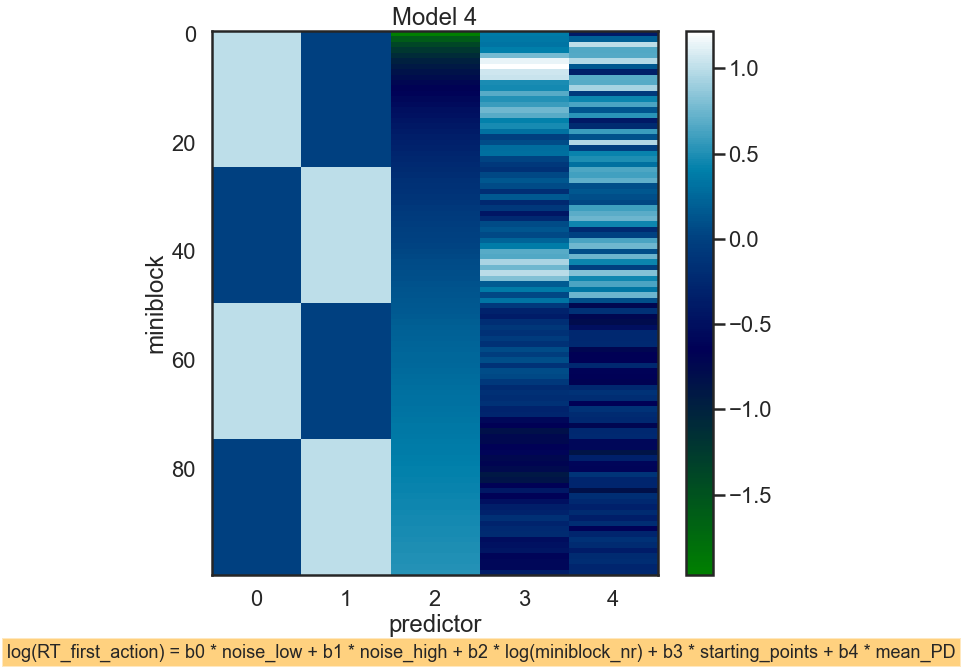

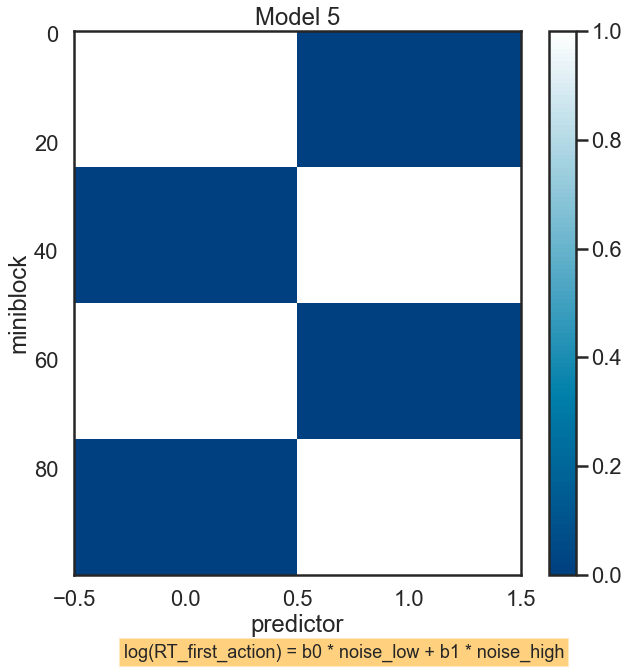

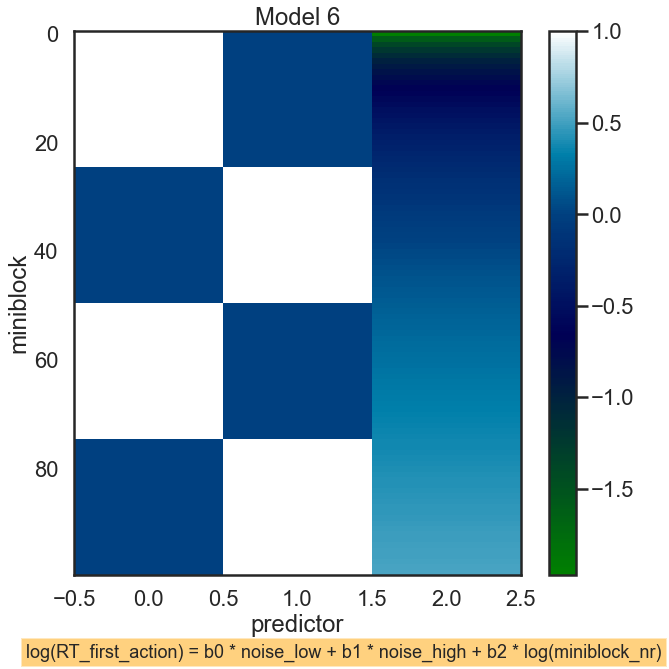

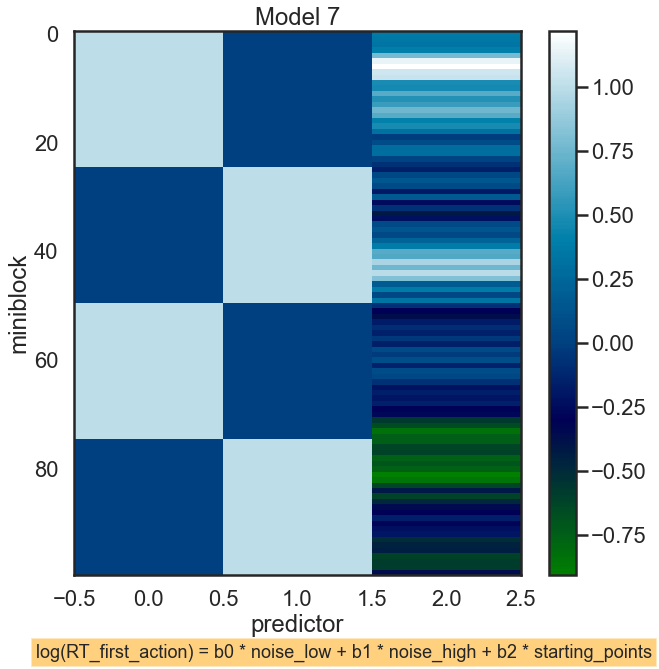

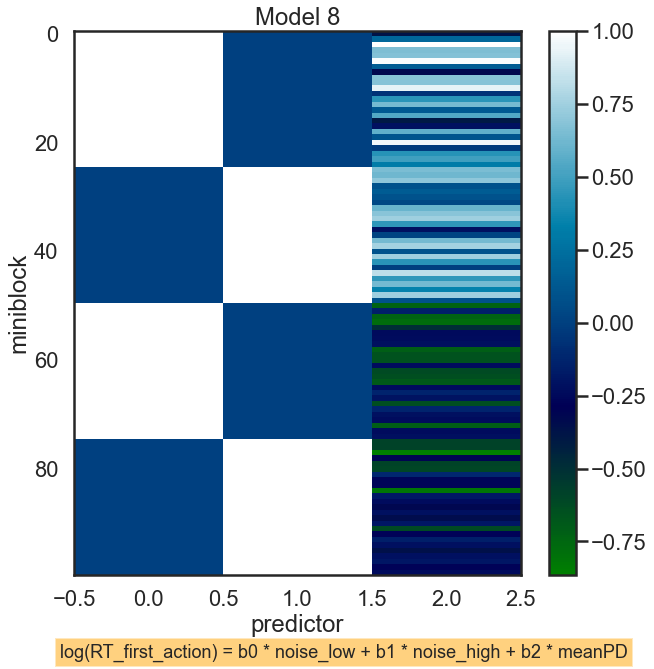

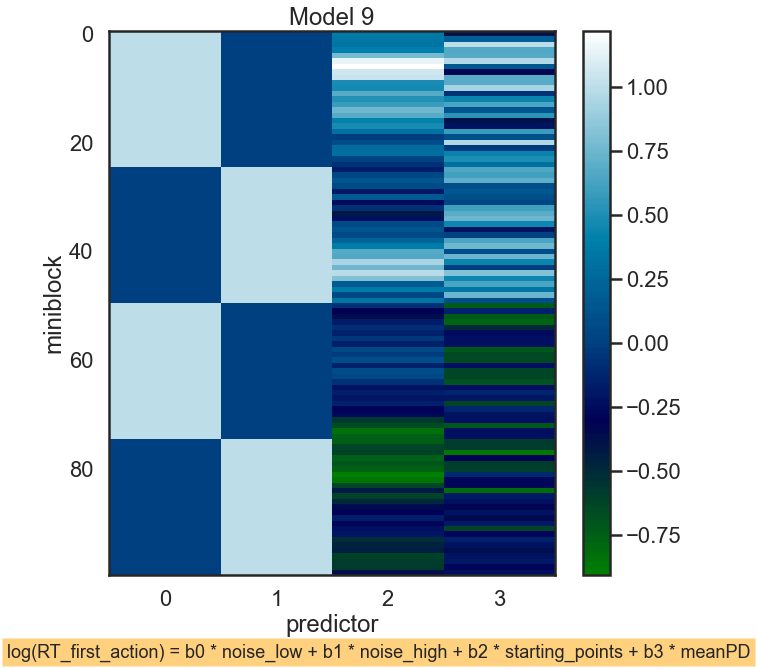

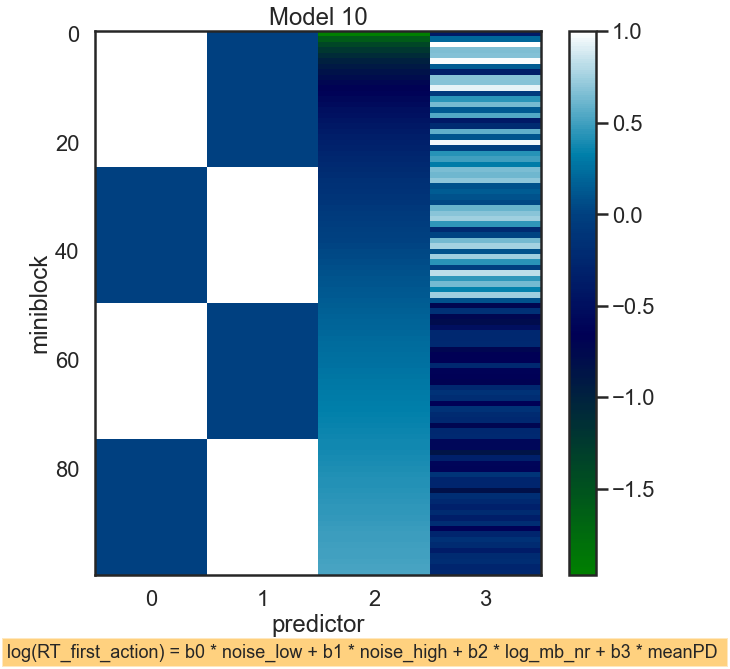

sample: 100%|██████████| 6000/6000 [01:24<00:00, 71.10it/s, 511 steps of size 8.89e-03. acc. prob=0.94] 


model waic -2448.4167


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2452.0696


sample: 100%|██████████| 6000/6000 [01:29<00:00, 66.94it/s, 511 steps of size 1.07e-02. acc. prob=0.92] 


model waic -2383.9124


sample: 100%|██████████| 6000/6000 [01:40<00:00, 59.79it/s, 511 steps of size 1.21e-02. acc. prob=0.88] 


model waic -2386.9106


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2452.1763


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2382.7612


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2408.4407


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2426.355


  0%|          | 0/6000 [00:00<?, ?it/s]

model waic -2406.1184


sample: 100%|██████████| 6000/6000 [01:27<00:00, 68.84it/s, 511 steps of size 1.15e-02. acc. prob=0.81] 


model waic -2386.761


In [11]:
samples_young, waic_young = sample_posterior(data_young, states_young, responses_young)

Bellow we visualise the results of linear regression for young and old adults

In [12]:
### visualise regression results ###

import numpy as onp

model_nr = len(samples_old)

betas = {'old': [], 'young': []}
for smpl1, smpl2 in zip(samples_old, samples_young):
    betas['old'].append(onp.array(smpl1['beta']).astype(onp.double))
    betas['young'].append(onp.array(smpl2['beta']).astype(onp.double))
    

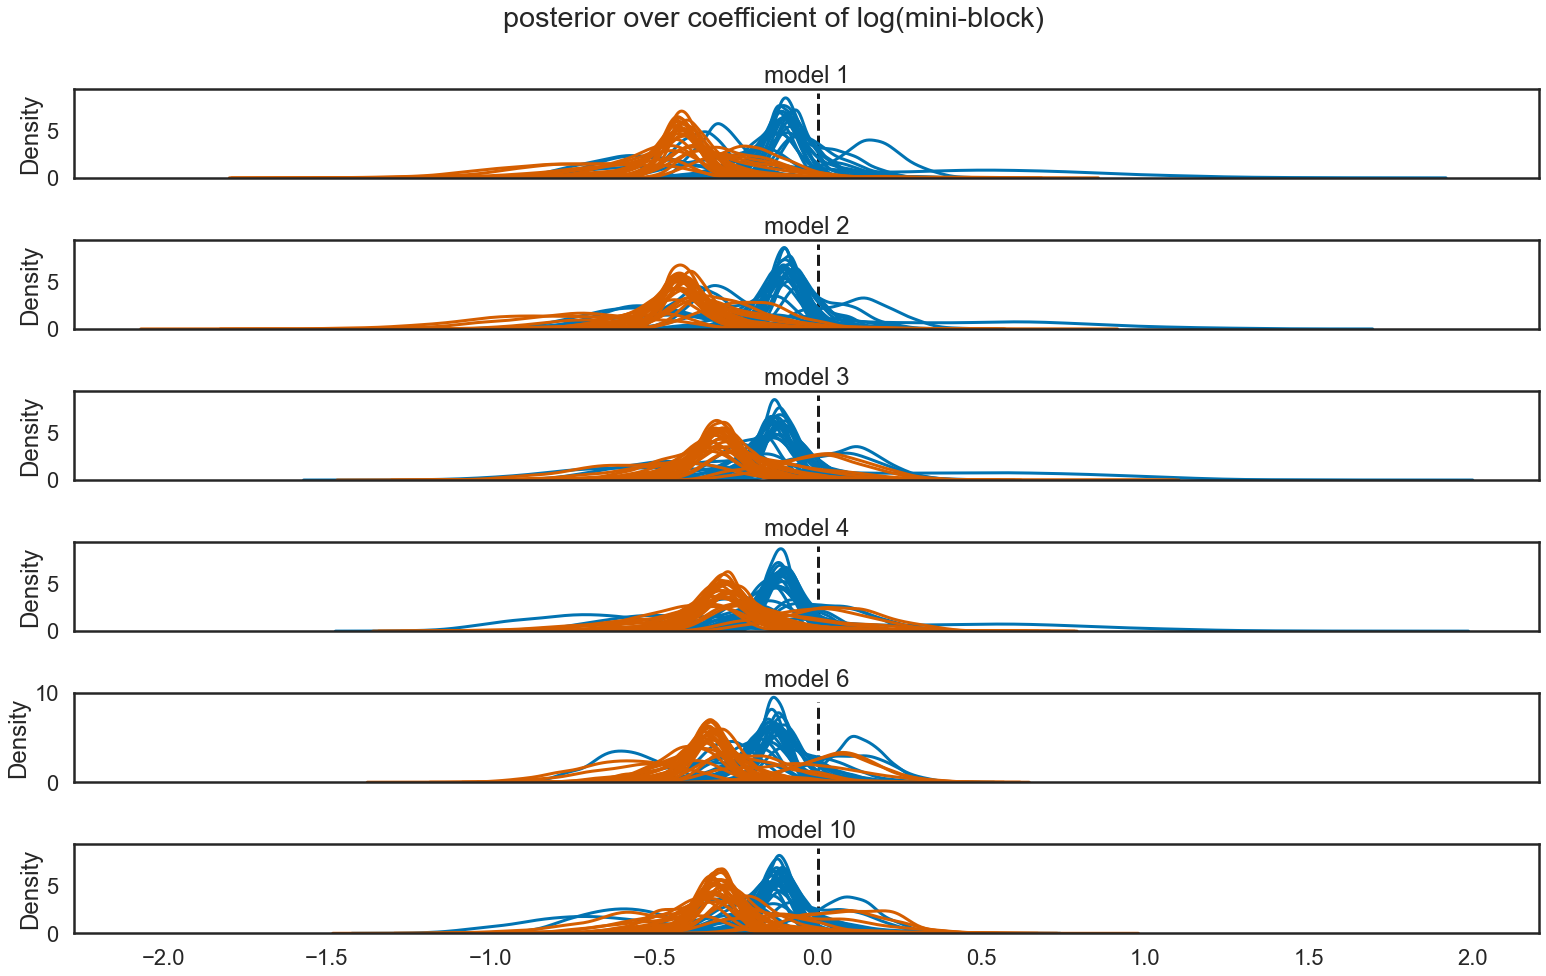

In [13]:
fig, ax = plt.subplots(6, 1, sharex = True, figsize=(22, 14))

color = {'old': 'b', 'young': 'r'}

for group in betas:
    n_sub = betas[group][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group][0][:, i, 1], color=color[group], alpha=.5, label=i+1, ax=ax[0], legend=False)
        sns.kdeplot(betas[group][1][:, i, 1], color=color[group], alpha=.5, label=i+1, ax=ax[1], legend=False)
        sns.kdeplot(betas[group][2][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[2], legend=False)
        sns.kdeplot(betas[group][3][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[3], legend=False)
        sns.kdeplot(betas[group][5][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[4], legend=False)
        sns.kdeplot(betas[group][9][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[5], legend=False)

fig.suptitle('posterior over coefficient of log(mini-block)');
for i in range(ax.size):
    ax[i].vlines(0, 0, 9, 'k', linestyle='--');
    #ax[i].xaxis.set_tick_params(which='both', labelbottom=True)

ax[0].set_title('model 1')
ax[1].set_title('model 2')
ax[2].set_title('model 3')
ax[3].set_title('model 4')
ax[4].set_title('model 6')
ax[5].set_title('model 10')
plt.tight_layout()

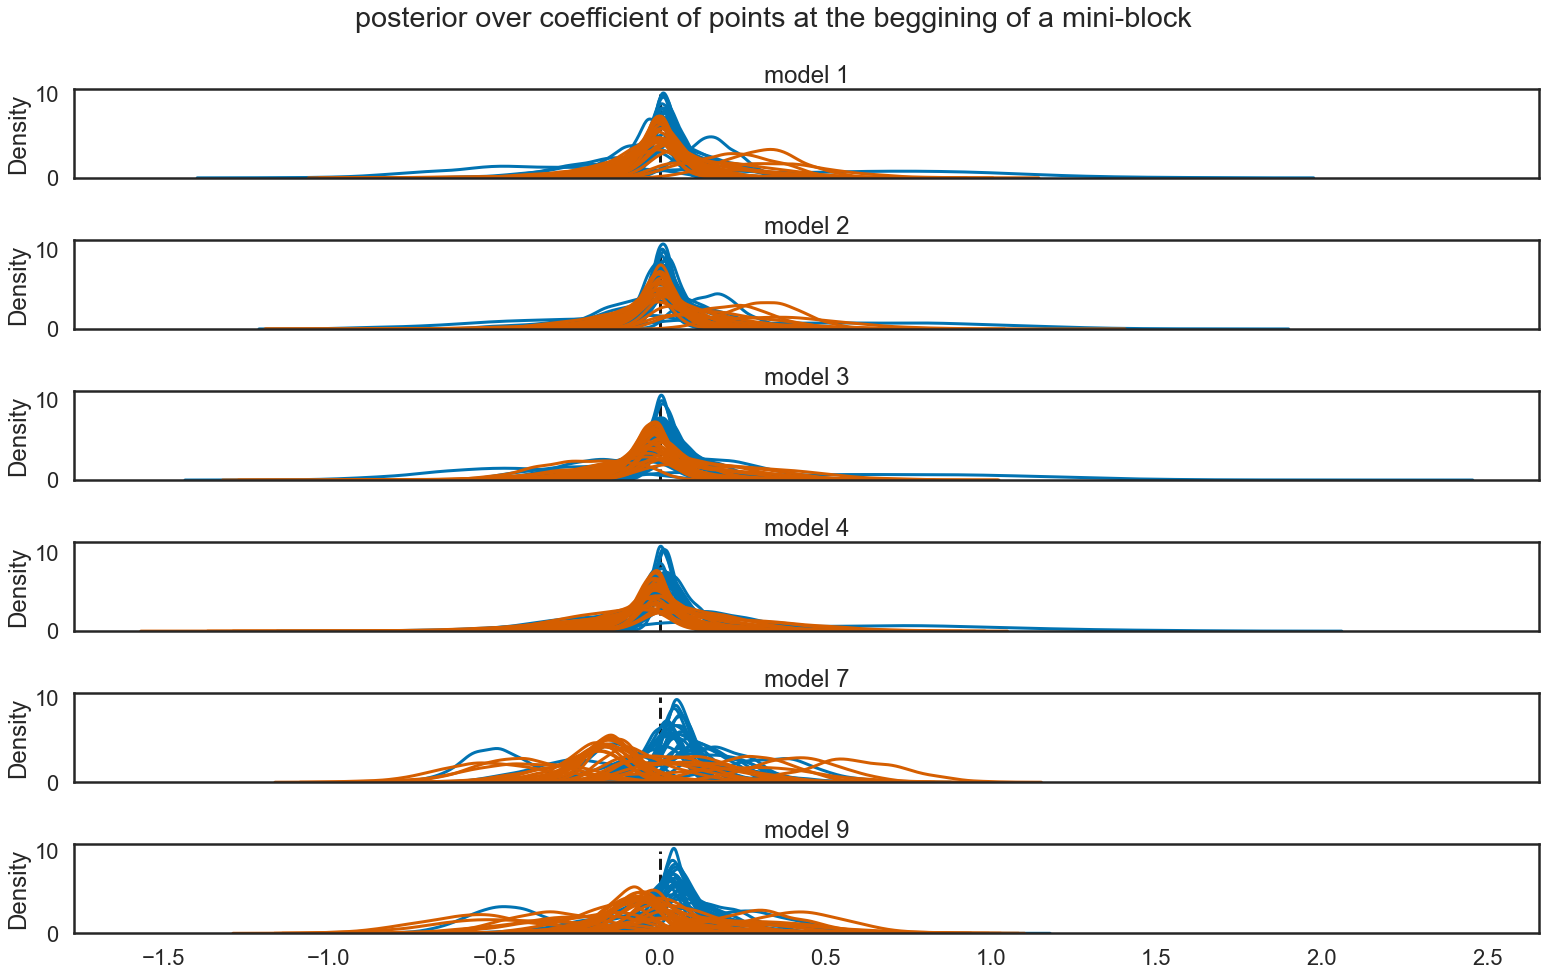

In [14]:
fig, ax = plt.subplots(6, 1, sharex = True, figsize=(22, 14))
color = {'old': 'b', 'young': 'r'}

for group in betas:
    n_sub = betas[group][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group][0][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[0], legend=False)
        sns.kdeplot(betas[group][1][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[1], legend=False)
        sns.kdeplot(betas[group][2][:, i, 3], color=color[group], alpha=.5, label=i+1, ax=ax[2], legend=False)
        sns.kdeplot(betas[group][3][:, i, 3], color=color[group], alpha=.5, label=i+1, ax=ax[3], legend=False)
        sns.kdeplot(betas[group][6][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[4], legend=False)
        sns.kdeplot(betas[group][8][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[5], legend=False)

fig.suptitle('posterior over coefficient of points at the beggining of a mini-block');
for i in range(ax.size):
    ax[i].vlines(0, 0, 10, 'k', linestyle='--');
    #ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
ax[0].set_title('model 1')
ax[1].set_title('model 2')
ax[2].set_title('model 3')
ax[3].set_title('model 4')
ax[4].set_title('model 7')
ax[5].set_title('model 9')
plt.tight_layout()

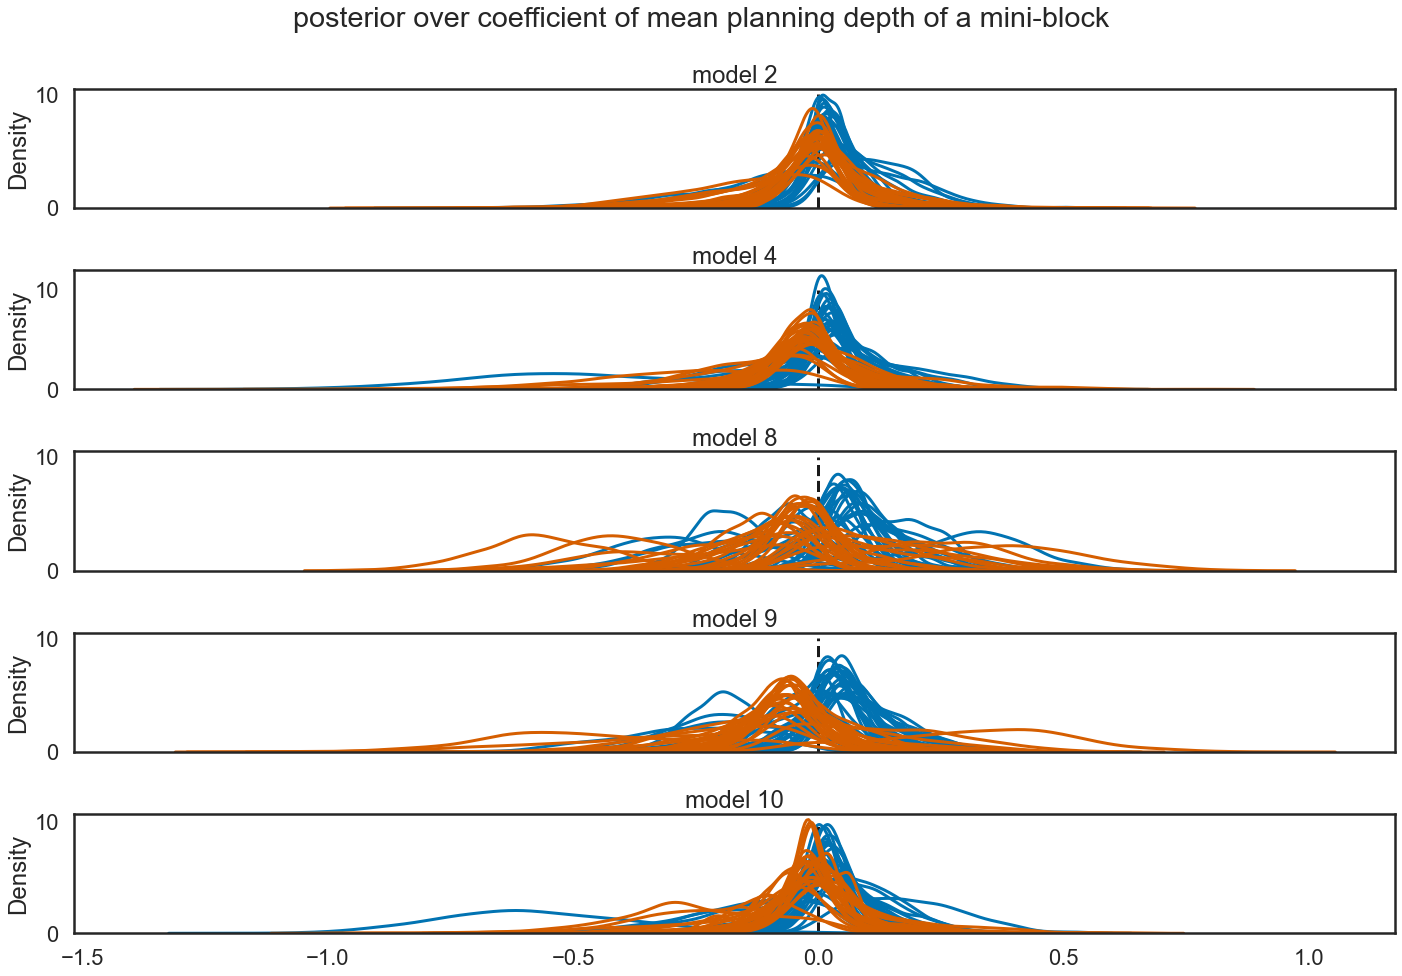

In [15]:
fig, ax = plt.subplots(5, 1, sharex = True, figsize=(20, 14))
color = {'old': 'b', 'young': 'r'}

for group in betas:
    n_sub = betas[group][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group][1][:, i, 3], color=color[group], alpha=.5, label=i+1, ax=ax[0], legend=False)
        sns.kdeplot(betas[group][3][:, i, 4], color=color[group], alpha=.5, label=i+1, ax=ax[1], legend=False)
        sns.kdeplot(betas[group][7][:, i, 2], color=color[group], alpha=.5, label=i+1, ax=ax[2], legend=False)
        sns.kdeplot(betas[group][8][:, i, 3], color=color[group], alpha=.5, label=i+1, ax=ax[3], legend=False)
        sns.kdeplot(betas[group][9][:, i, 3], color=color[group], alpha=.5, label=i+1, ax=ax[4], legend=False)

fig.suptitle('posterior over coefficient of mean planning depth of a mini-block');
for i in range(ax.size):
    ax[i].vlines(0, 0, 10, 'k', linestyle='--');
    #ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
ax[0].set_title('model 2');
ax[1].set_title('model 4');
ax[2].set_title('model 8');
ax[3].set_title('model 9');
ax[4].set_title('model 10');
plt.tight_layout()

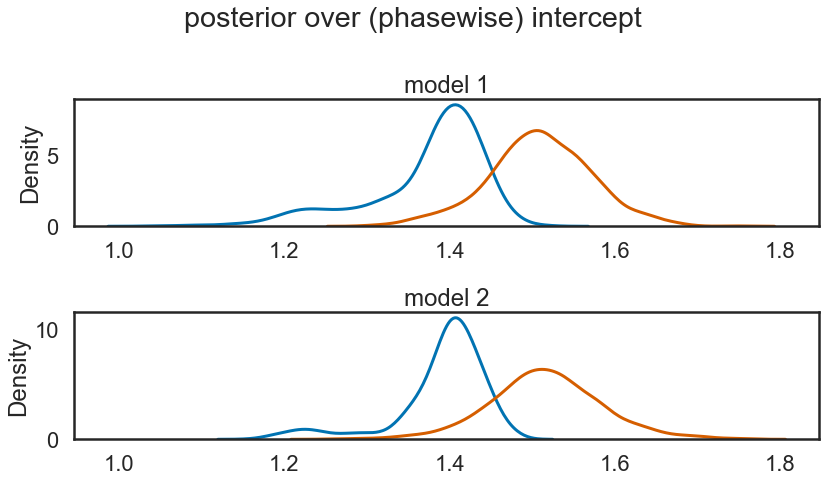

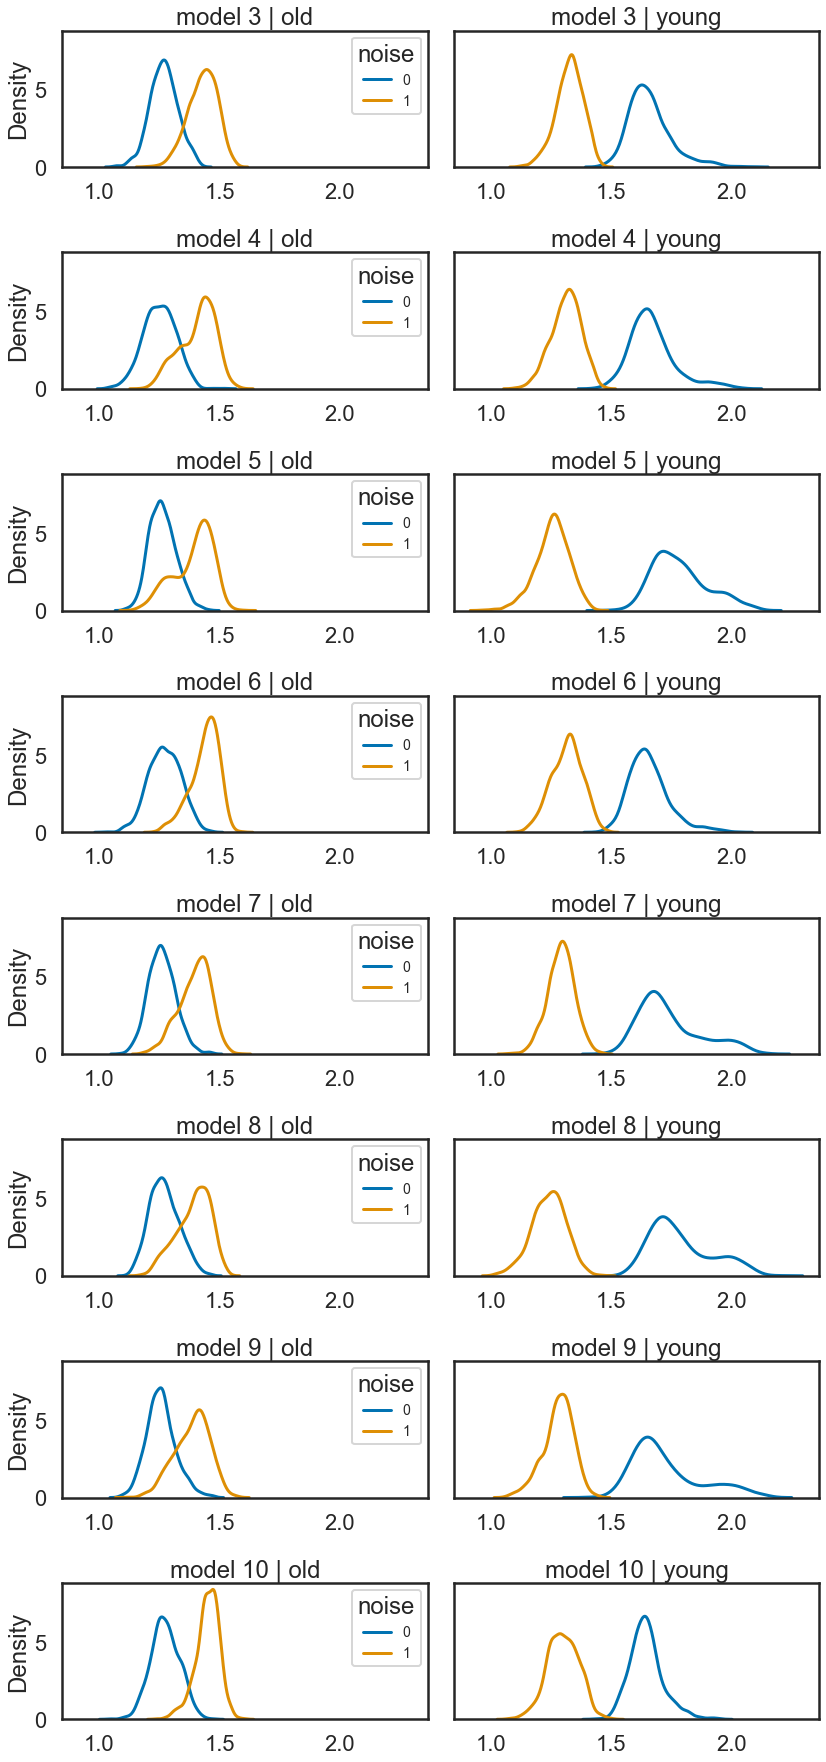

In [16]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(12, 7))
color = {'old': 'b', 'young': 'r'}
colors = ['b','r']

smpl_old = onp.array(samples_old)
smpl_young = onp.array(samples_young)

for i, smpl in enumerate([smpl_old, smpl_young]):
    sns.kdeplot(smpl[0]['group_beta'][:, 0], color=colors[i], alpha=.5, label=i+1, ax=ax[0], legend=False)
    sns.kdeplot(smpl[1]['group_beta'][:, 0], color=colors[i], alpha=.5, label=i+1, ax=ax[1], legend=False)

fig.suptitle('posterior over (phasewise) intercept');
ax[0].set_title('model 1')
ax[1].set_title('model 2')
ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()


fig, ax = plt.subplots(8, 2,sharex = True, sharey = True, figsize=(12, 25))
for i, smpl in enumerate([smpl_old, smpl_young]):
    for j in range(2):
        sns.kdeplot(smpl[2]['group_beta'][:, j], label=j, ax=ax[0,i], legend=False)
        sns.kdeplot(smpl[3]['group_beta'][:, j], label=j, ax=ax[1,i], legend=False)
        sns.kdeplot(smpl[4]['group_beta'][:, j], label=j, ax=ax[2,i], legend=False)
        sns.kdeplot(smpl[5]['group_beta'][:, j], label=j, ax=ax[3,i], legend=False)
        sns.kdeplot(smpl[6]['group_beta'][:, j], label=j, ax=ax[4,i], legend=False)
        sns.kdeplot(smpl[7]['group_beta'][:, j], label=j, ax=ax[5,i], legend=False)
        sns.kdeplot(smpl[8]['group_beta'][:, j], label=j, ax=ax[6,i], legend=False)
        sns.kdeplot(smpl[9]['group_beta'][:, j], label=j, ax=ax[7,i], legend=False)

for i in range(ax.shape[0]):
    ax[i,0].set_title('model '+str(i+3)+' | old')
    ax[i,1].set_title('model '+str(i+3)+' | young')
    ax[i,0].legend(title='noise', prop={'size': 14});
    ax[i,0].xaxis.set_tick_params(which='both', labelbottom=True)
    ax[i,1].xaxis.set_tick_params(which='both', labelbottom=True)

plt.tight_layout()

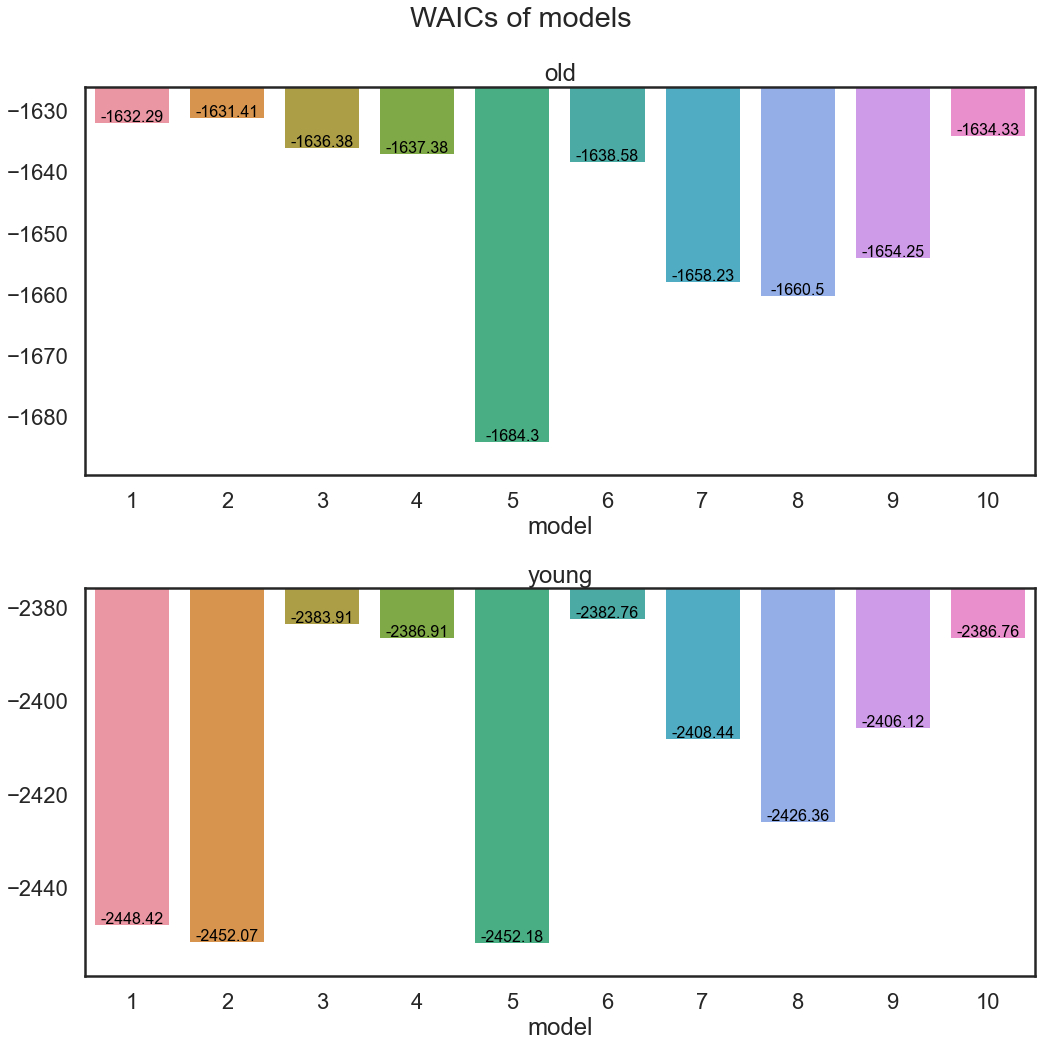

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
fig.suptitle('WAICs of models')

g1 = sns.barplot(x = list(range(1,11)), y=onp.array(waic_old), ax=ax[0])
g2 = sns.barplot(x = list(range(1,11)), y=onp.array(waic_young), ax=ax[1])

padding_old = 0.1*(max(waic_old) - min(waic_old))
padding_young = 0.1*(max(waic_young) - min(waic_young))

ax[0].set(ylim=(min(waic_old)-padding_old, max(waic_old)+padding_old))
ax[1].set(ylim=(min(waic_young)-padding_young, max(waic_young)+padding_young))
ax[0].set_xlabel('model')
ax[1].set_xlabel('model')
ax[0].set_title('old')
ax[1].set_title('young')

for i in range(len(waic_old)):
    g1.text(i, waic_old[i], round(waic_old[i],2), color='black', ha="center", va ="bottom", size="16")
    g2.text(i, waic_young[i], round(waic_young[i],2), color='black', ha="center", va ="bottom", size="16")

plt.tight_layout()